In [1]:
import numpy as np
import pandas as pd
import time
from itertools import combinations
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC,NuSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
import sys
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.preprocessing as preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
import copy
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import collections
import statsmodels.formula.api as sm

In [4]:
subbig = pd.read_csv('submissions/submission_ridge.csv')
subnew = pd.read_csv('submissions/submission_ridge_12072.csv')
subchaz = pd.read_csv('submissions/submission_ridge_whole_train.csv')

In [8]:
np.mean(subnew.HTWins == subchaz.HTWins)

0.6911407766990292

In [2]:
df = pd.read_csv('train_156.csv')
df2 = pd.read_csv('test_155.csv')
df.drop('Unnamed: 0', axis = 1, inplace = True)
df2.drop('Unnamed: 0', axis = 1, inplace = True)

In [3]:
dfr = df.loc[:, 'VT':]
dft = df.loc[:,"HTWins"]
le = LabelEncoder()
le.fit(list(collections.Counter(dfr.VTleague).keys()))
dfr.VTleague = le.transform(dfr.VTleague)
le.fit(list(collections.Counter(dfr.HTleague).keys()))
dfr.HTleague = le.transform(dfr.HTleague)
le.fit(list(collections.Counter(dfr.HT).keys()))
dfr.HT = le.transform(dfr.HT)
le.fit(list(collections.Counter(dfr.VT).keys()))
dfr.VT = le.transform(dfr.VT)

In [4]:
hj = """VT.S1.plmin+VT.OS3.plmin+VT.OS1.plmin+VT.OTA.ast+VT.S3.plmin+VT.OS4.plmin+VT.S2.plmin+VT.OS2.plmin+VT.OTS.fgm+HT.S3.pts+VT.TA.pts+HT.S1.pts+VT.S4.plmin+VT.TA.ast+VT.OTA.dreb+VT.S5.stl+VT.OTS.pts+HT.OS3.dreb+VT.OS4.dreb""".split('+')

In [5]:
dfhj = dfr[hj]
dfhj.head()

,VT.S1.plmin,VT.OS3.plmin,VT.OS1.plmin,VT.OTA.ast,VT.S3.plmin,VT.OS4.plmin,VT.S2.plmin,VT.OS2.plmin,VT.OTS.fgm,HT.S3.pts,VT.TA.pts,HT.S1.pts,VT.S4.plmin,VT.TA.ast,VT.OTA.dreb,VT.S5.stl,VT.OTS.pts,HT.OS3.dreb,VT.OS4.dreb
0,6.00356,-1.82521,8.13090,18.44003,3.00893,3.88749,4.67069,4.76800,35.68173,12.43087,92.41832,19.05546,1.66659,16.99671,28.97146,0.35244,95.67931,4.45854,2.10702
1,-4.29929,0.94270,2.31685,15.88236,-4.94617,8.38263,-3.17935,2.31911,39.60178,10.93412,94.37342,18.85648,-4.87218,19.34533,33.20054,0.20237,101.88801,4.22546,4.55217
2,5.33447,3.44609,1.33395,23.03062,2.47097,0.89073,2.76411,2.89079,36.07819,13.24354,96.08555,16.98558,2.05847,20.46105,31.15797,1.06787,98.29040,3.87238,5.38000
3,-3.88569,-3.94261,-0.56155,22.32009,2.17797,-1.29366,-6.50419,-2.64727,38.17520,10.16629,94.60220,22.98232,-1.23816,19.81513,27.86553,0.00132,99.02270,1.57741,3.51931
4,-1.29586,6.72873,6.11820,19.18875,0.33257,6.06255,-1.29616,4.37270,34.01666,12.77098,93.37065,18.01167,-1.46404,18.45130,28.99182,0.62256,91.89461,5.72281,2.65682


In [6]:
dfhj.shape

(9520, 19)

## Var Select

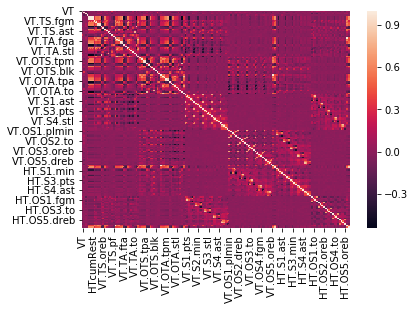

In [67]:
corr = dfr.corr()
sns.heatmap(corr)

In [11]:
# Drop >0.9 corr ones
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.9:
            if columns[j]:
                columns[j] = False
selected_columns = dfr.columns[columns]
dfr = dfr[selected_columns]

In [12]:
def backwardElimination(x, Y, sl, columns):
    numVars = len(x[0])
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(Y, x).fit()
        maxVar = max(regressor_OLS.pvalues).astype(float)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)
                    columns = np.delete(columns, j)
                    
    regressor_OLS.summary()
    return x, columns

In [13]:
SL = 0.005
data_modeled, selected_columns = backwardElimination(dfr.values, dft.values, SL, selected_columns)

In [69]:
result = pd.DataFrame()
result['HTWins'] = dft
data = pd.DataFrame(data = data_modeled, columns = selected_columns)

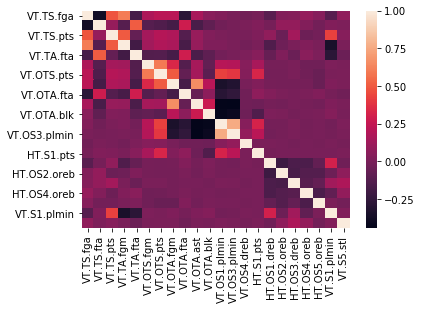

In [70]:
corr = data.corr()
sns.heatmap(corr)

In [68]:
data_modeled, selected_columns = backwardElimination(data.values, dft.values, 0.01, selected_columns)

In [71]:
data.shape

(9520, 22)

In [35]:
newcol=data.columns.tolist()+hj

In [60]:
data = dfr[selected_columns]

In [61]:
dtest=df2[selected_columns]

In [47]:
# Drop >0.8 corr ones
columns = np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >= 0.8:
            if columns[j]:
                columns[j] = False
selected_columns = data.columns[columns]
data = data[selected_columns]

In [62]:
data.columns

Index(['VT.TS.fga', 'VT.TS.fta', 'VT.TS.pts', 'VT.TA.fgm', 'VT.TA.tpa',
       'VT.TA.fta', 'VT.OTS.fgm', 'VT.OTS.pts', 'VT.OTA.fgm', 'VT.OTA.fta',
       'VT.OTA.ast', 'VT.OTA.blk', 'VT.S5.pts', 'VT.OS1.plmin', 'VT.OS3.plmin',
       'VT.OS3.fgm', 'VT.OS4.dreb', 'HT.S1.pts', 'HT.OS1.dreb', 'HT.OS2.oreb',
       'HT.OS3.dreb', 'HT.OS4.oreb', 'HT.OS5.oreb', 'VT.S1.plmin',
       'VT.S3.plmin', 'VT.OS4.plmin', 'VT.S2.plmin', 'VT.OS2.plmin',
       'VT.S4.plmin', 'VT.TA.ast', 'VT.OTA.dreb', 'VT.S5.stl'],
      dtype='object')

In [52]:
len(newcol)

59

In [72]:
x_train, x_test, y_train, y_test = train_test_split(preprocessing.normalize(data.values), result.values, test_size = 0.2)

## Model Fitting

In [7]:
# The following def are packages training, which can be searched on sklearn

def KNN(n,x,y):
    knn = KNeighborsClassifier(n_neighbors=n, n_jobs=-1)
    knn.fit(x,y)
    return knn


def SVM(x,y):
    svc = SVC()
    svc.fit(x,y)
    return svc


def NuSVM(x,y):
    nus = [_ / 10 for _ in range(1, 11, 1)]
    for nu in nus:
        nusvc = NuSVC(nu=nu)
        try:
            nusvc.fit(x,y)
            return nusvc
        except ValueError as e:
            print("nu {} not feasible".format(nu))

def Bayesian(x,y):
    bayesian = GaussianNB()
    bayesian.fit(x,y)
    return bayesian


def DecisionTree(x,y,criterion='gini',max_depth=None, min_samples_split=2, min_samples_leaf=1, max_features=None):
    Tree = DecisionTreeClassifier(criterion=criterion,max_depth=max_depth,min_samples_split= \
                                               min_samples_split,min_samples_leaf=min_samples_leaf,
                                               max_features=max_features)
    Tree.fit(x,y)
    return Tree


def RandomForest(x,y,n_estimator=10,criterion='gini'):
    Forest = RandomForestClassifier(n_estimators=n_estimator,criterion=criterion)
    Forest.fit(x,y)
    return Forest


def LinearC(x,y):
    linear = SGDClassifier()
    linear.fit(x,y)
    return linear


def MLP(x,y,hidden_layer_size=(100,),activation='relu',solver='adam',learning_rate_init=0.01, learning_rate='adaptive'):
    if solver=='adam':
        MLP = MLPClassifier(hidden_layer_sizes=hidden_layer_size, activation=activation, solver= \
                                               solver, learning_rate_init=learning_rate_init, learning_rate=learning_rate)
    elif solver=='sgd':
        MLP = MLPClassifier(hidden_layer_sizes=hidden_layer_size, activation=activation, solver= \
            solver, learning_rate_init=learning_rate_init)
    else:
        MLP = MLPClassifier(hidden_layer_sizes=hidden_layer_size, activation=activation, solver= \
            solver)
    MLP.fit(x,y)
    return MLP

In [8]:
# Hand Written Soft Voting
def Vote(Classifier,Prediction,Score):
    leng = len(Classifier)
    sum_score = sum(Score)
    Weighted = 0
    for i in range(leng):
        Weighted += Prediction[i]*Score[i]/sum_score
    return Weighted

In [9]:
# Model Prediction
def model_predict(model,x):
    return model.predict(x)

In [10]:
Classifiers = []
# If I comment the append instruction, the algorithm is not included into bagging or boosting
clf1 = KNeighborsClassifier(n_neighbors=2)
#Classifiers.append(('KNeighborsClassifier',clf1))
clf2 = SVC(probability=True)
Classifiers.append(('SVC',clf2))
clf3 = NuSVC(nu=0.1,probability=True)
Classifiers.append(('NuSVC',clf3))
clf4 = GaussianNB()
Classifiers.append(('GaussianNB',clf4))
clf5 = DecisionTreeClassifier()
Classifiers.append(('DecisionTreeClassifier',clf5))
clf6 = RandomForestClassifier(n_estimators=2,criterion='gini')
Classifiers.append(('RandomForestClassifier1',clf6))
clf7 = RandomForestClassifier(n_estimators=2,criterion='entropy')
Classifiers.append(('RandomForestClassifier2',clf7))
clf8 = SGDClassifier(loss='modified_huber')
Classifiers.append(('SGDClassifier',clf8))
clf9 = MLPClassifier()
#Classifiers.append(('MLPClassifier',clf9))

# Create two bagging classifiers
eclf1 = VotingClassifier(estimators=Classifiers,voting='hard')
eclf2 = VotingClassifier(estimators=Classifiers,voting='soft')

### AdaBoost w soft bagging

In [31]:
start_time = time.time()
# Create the boosting classifier based on soft bagging
Boost = AdaBoostClassifier(base_estimator=eclf2,n_estimators=10)
Boost.fit(x_train,y_train)
score = Boost.score(x_test,y_test)
pred = Boost.predict(x_test)
sub2 = Boost.predict(dtest.values)
print("Classification Report of Boosting: ")
print(classification_report(y_test,pred))
print('Time Cost for the Program: %s' % (time.time()-start_time))

Classification Report of Boosting: 
              precision    recall  f1-score   support

           0       0.61      0.47      0.53       756
           1       0.70      0.80      0.74      1148

   micro avg       0.67      0.67      0.67      1904
   macro avg       0.65      0.63      0.64      1904
weighted avg       0.66      0.67      0.66      1904

Time Cost for the Program: 224.0343325138092


In [25]:
start_time = time.time()
# Create the boosting classifier based on soft bagging - entire dataset
Boost = AdaBoostClassifier(base_estimator=eclf2,n_estimators=10)
Boost.fit(data.values,result.values)
score = Boost.score(x_test,y_test)
pred = Boost.predict(x_test)
sub = Boost.predict(dtest.values)
print("Classification Report of Boosting: ")
print(classification_report(y_test,pred))
print('Time Cost for the Program: %s' % (time.time()-start_time))

Classification Report of Boosting: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       756
           1       1.00      1.00      1.00      1148

   micro avg       1.00      1.00      1.00      1904
   macro avg       1.00      1.00      1.00      1904
weighted avg       1.00      1.00      1.00      1904

Time Cost for the Program: 360.32200384140015


In [32]:
sum(sub2 == sub)/len(sub)

0.7773058252427184

### Bagging

In [77]:
# Hand Written Bagging
Classifier = []
Score = []
Prediction = []
Classifier.append(KNN(2,x_train,y_train))
print('KNN Train Finished')
Classifier.append(SVM(x_train,y_train))
print('SVM Train Finished')
Classifier.append(NuSVM(x_train,y_train))
print('NuSVM Train Finished')
Classifier.append(Bayesian(x_train,y_train))
print('Bayesian Train Finished')
Classifier.append(DecisionTree(x_train,y_train))
print('Decision Tree Train Finished')
Classifier.append(RandomForest(x_train,y_train,n_estimator=2))
print('Random Forest Gini Train Finished')
Classifier.append(RandomForest(x_train,y_train,n_estimator=2,criterion='entropy'))
print('Random Forest Entropy Train Finished')
Classifier.append(LinearC(x_train,y_train))
print('Linear Model Train Finished')
Classifier.append(MLP(x_train,y_train))
print('MLP Train Finished')
Classifier.append(LinearDiscriminantAnalysis().fit(x_train, y_train))
print('LDA Train Finished')
Classifier.append(LogisticRegression(random_state=101).fit(x_train, y_train))
print('LogReg Train Finished')

KNN Train Finished
SVM Train Finished
NuSVM Train Finished
Bayesian Train Finished
Decision Tree Train Finished
Random Forest Gini Train Finished
Random Forest Entropy Train Finished
Linear Model Train Finished
MLP Train Finished
LDA Train Finished
LogReg Train Finished


In [78]:
# Test the Accuracy of Each Classifier
for i in range(len(Classifier)):
    num = 0
    y_predict = Classifier[i].predict(x_test)
    print("Classification Report: {}".format(Classifier[i]))
    print(classification_report(y_test,y_predict))
    for j in range(x_test.shape[0]):
        if y_predict[j]==y_test[j]:
            num+=1
    Score.append(num/x_test.shape[0])
Overall_Acc = 0

Classification Report: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=-1, n_neighbors=2, p=2,
           weights='uniform')
              precision    recall  f1-score   support

           0       0.49      0.73      0.59       788
           1       0.71      0.46      0.56      1116

   micro avg       0.57      0.57      0.57      1904
   macro avg       0.60      0.60      0.57      1904
weighted avg       0.62      0.57      0.57      1904

Classification Report: SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       788
           1       0.59      1.00      0.74      1116

   micro avg       0.59      0.59      0.59      1904
   macro

In [29]:
for i in selected_columns.tolist():
    if i not in orils:
        print(i)

HT.S3.pts
HT.OS5.fgm


In [30]:
for i in orils:
    if i not in selected_columns.tolist():
        print(i)

VT.OTA.tpa


In [28]:
orils= """VT.TS.fga
VT.TS.fta
VT.TS.pts
VT.TA.fgm
VT.TA.tpa
VT.TA.fta
VT.OTS.fgm
VT.OTS.pts
VT.OTA.fgm
VT.OTA.tpa
VT.OTA.fta
VT.OTA.ast
VT.OTA.blk
VT.S5.pts
VT.OS1.plmin
VT.OS3.plmin
VT.OS3.fgm
VT.OS4.dreb
HT.S1.pts
HT.OS1.dreb
HT.OS2.oreb
HT.OS3.dreb
HT.OS4.oreb
HT.OS5.oreb""".split('\n')

## NN

In [46]:
import keras

Using TensorFlow backend.


In [92]:
from keras.utils import to_categorical
#one-hot encode target column
train_y_2 = to_categorical(y_train)

#vcheck that target column has been converted
train_y_2[0:5]


array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [101]:
test_y_2 = to_categorical(y_test)

#vcheck that target column has been converted
test_y_2[0:5]

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [103]:
whole_y = to_categorical(result.values)

#vcheck that target column has been converted
whole_y[0:5]

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [104]:
#create model
model_2 = keras.Sequential()

#get number of columns in training data
n_cols_2 = x_train.shape[1]

#add layers to model
model_2.add(keras.layers.Dense(250, activation='relu', input_shape=(n_cols_2,)))
model_2.add(keras.layers.Dense(300, activation='relu'))
model.add(keras.layers.Dropout(rate=0.2))
model_2.add(keras.layers.Dense(250, activation='relu'))
model_2.add(keras.layers.Dense(2, activation='softmax'))

#compile model using accuracy to measure model performance
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#train model
model_2.fit(x_train, train_y_2, epochs=50, validation_split=0.2)

# Print the Evaluation of the Model
print('Loss, Acc for Test Set:', model.evaluate(x_test,test_y_2))
print()
print('Loss, Acc for Whole Set:', model.evaluate(preprocessing.normalize(data.values), whole_y))

Train on 6092 samples, validate on 1524 samples
Epoch 1/50
6092/6092 [==============================] - 2s 275us/step - loss: 0.6629 - accuracy: 0.6000 - val_loss: 0.6733 - val_accuracy: 0.6129
Epoch 2/50
6092/6092 [==============================] - 1s 158us/step - loss: 0.6379 - accuracy: 0.6339 - val_loss: 0.6357 - val_accuracy: 0.6496
Epoch 3/50
6092/6092 [==============================] - 1s 159us/step - loss: 0.6346 - accuracy: 0.6359 - val_loss: 0.6357 - val_accuracy: 0.6430
Epoch 4/50
6092/6092 [==============================] - 1s 158us/step - loss: 0.6291 - accuracy: 0.6495 - val_loss: 0.6350 - val_accuracy: 0.6522
Epoch 5/50
6092/6092 [==============================] - 1s 160us/step - loss: 0.6221 - accuracy: 0.6484 - val_loss: 0.6345 - val_accuracy: 0.6391
Epoch 6/50
6092/6092 [==============================] - 1s 161us/step - loss: 0.6233 - accuracy: 0.6530 - val_loss: 0.6262 - val_accuracy: 0.6549
Epoch 7/50
6092/6092 [==============================] - 1s 162us/step - loss

ValueError: Error when checking target: expected dropout_26 to have shape (1,) but got array with shape (2,)

In [61]:
Weight = model.model.predict_classes(preprocessing.normalize(dtest.values))
print(Weight)

[[0]
 [0]
 [1]
 ...
 [1]
 [1]
 [1]]


In [72]:
Weight2 = model.model.predict_classes(preprocessing.normalize(dtest.values))

In [68]:
ls = []
for i in Weight:
    ls.append(i[0])

In [73]:
ls2 = []
for i in Weight2:
    ls2.append(i[0])

In [74]:
collections.Counter(ls2)

Counter({1: 1648})

In [69]:
collections.Counter(ls)

Counter({0: 585, 1: 1063})

## Submission

In [26]:
collections.Counter(sub)

Counter({1: 1349, 0: 299})

In [ ]:
htwins = []
for i in range(len(sub)):
    if sub[i] == 0: 
        htwins.append('No')
    else:
        htwins.append('Yes')
sub_pred = pd.DataFrame({'id':df2.loc[:,'id'],'HTWins':htwins})

sub_pred.to_csv("submission_boost.csv", index = False)